# This notebook is used to determine the output of the calibration illumination system and measure the amount of signal on the detector from an ATArchiver image. The code is meant for flats, but can be used for other purposes.

In [653]:
from astropy.io import fits
import astropy.stats
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import csv
import pickle

import warnings
#import matplotlib.pyplot as plt  # imported as py above
from astropy.modeling import models, fitting
from scipy.ndimage.filters import gaussian_filter
from matplotlib import pyplot as plt

In [2]:
import lsst.ts

Could not import lsstcppimport; please ensure the base package has been built (not just setup).



In [1512]:
# the calsys_take_narrowband_data script outputs a CSV file, but the URLs are messed up. So this fixes them and writes a new file
new_rows = []
csv_dir='/home/saluser/develop/calsys_take_narrowband_data_fits_files/'
#csv_dir='/home/saluser/develop/calsys_take_test_data_fits_files/'
#csv_dir='/home/saluser/develop/'
csv_filename_root='calsys_take_narrowband_data_2019-04-12'
#csv_filename_root='calsys_take_narrowband_data_2019-04-03'

with open(csv_dir+csv_filename_root+'.csv',"r") as csvfile:
    data_reader = csv.DictReader(csvfile)
    headers = data_reader.fieldnames
    for row in data_reader:
        new_row = row
        electrometer_url = row["Electrometer Fits File"]
        fiber_spectrograph_url = row["Fiber Spectrograph Fits File"]
        electrometer_name = electrometer_url.split('/')[-1]
        new_row["Electrometer Fits File"] = electrometer_name + ".fits"
        fiber_spectrograph_name = fiber_spectrograph_url.split('/')[-1]
        new_row["Fiber Spectrograph Fits File"] = fiber_spectrograph_name
        new_rows.append(new_row)
with open(csv_dir+csv_filename_root+'-reformatted.csv',"w") as csvfile:
    data_writer = csv.DictWriter(csvfile, fieldnames=headers)
    data_writer.writeheader()
    for row in new_rows:
        data_writer.writerow(row)

# Read in the CSV file which has cleaned URLs
new_rows = []
with open(csv_dir+csv_filename_root+'-reformatted.csv',"r") as csvfile:
    data_reader = csv.DictReader(csvfile)
    data_reader_list = list(data_reader)
    #exposure_time_1 = data_reader_list[0]["Exposure Time"]
    #print(exposure_time_1)

print(data_reader.fieldnames)

['ATArchiver Image Name', 'ATArchiver Image Sequence Name', 'Exposure Time', 'Fiber Spectrograph Exposure Time', 'Monochromator Grating', 'Monochromator Wavelength', 'Monochromator Entrance Slit Size', 'Monochromator Exit Slit Size', 'Fiber Spectrograph Fits File', 'Electrometer Fits File']


In [1513]:
# declare dictionary to store values
data_dict = {}

In [1514]:
index=-1
print(data_reader_list[index]['ATArchiver Image Name'])
print(data_reader_list[index]['Exposure Time'])
print(data_reader_list[index]['Fiber Spectrograph Exposure Time'])
print(data_reader_list[index]['Monochromator Wavelength'])
print(data_reader_list[index]['Monochromator Exit Slit Size'])

AT_O_20190412_000028-ats-wfs_ccd.fits
4.0
0.2
450.0
0.1


In [1515]:
# Read in a fiber spectrograph file, which is just the last one in the list
dir='/home/saluser/develop/calsys_take_narrowband_data_fits_files/fiber_spectrograph_fits_files/'
#dir='/home/saluser/develop/calsys_take_test_data_fits_files/fiber_spectrograph_fits_files/'
#filename=dir+'testKiloarc1553106436.910112.fits'
filename=dir+data_reader_list[index]['Fiber Spectrograph Fits File']

print('Opening file {}'.format(filename))
#fits_image_filename = fits.util.get_testdata_filepath(filename)
hdul = fits.open(filename)
xdata=(hdul[0].data)[:,0]
ydata=(hdul[0].data)[:,1]
#print(repr(hdul[0].header))

Opening file /home/saluser/develop/calsys_take_narrowband_data_fits_files/fiber_spectrograph_fits_files/testKiloarc1555109680.176963.fits


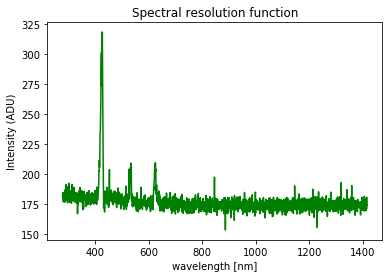

In [1516]:
if True:
    plt.ylabel('Intensity (ADU)')
    plt.plot(xdata, ydata,'-g')
    plt.title('Spectral resolution function')
    plt.xlabel('wavelength [nm]')
    plt.show()
    plt.close()

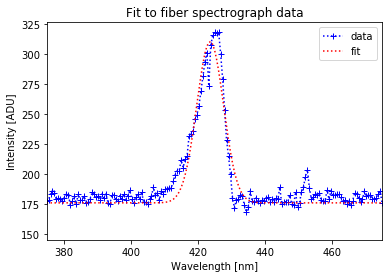

Amplitude [ADU] = 134
peak (mean) [nm] = 423.57
width (sigma) [nm] = 3.993
FWHM [nm] = 9.404


In [1517]:
# Fit a guassian to the profile
mean = xdata[np.argmax(ydata)] # assume the peak we want is the maximum value (NOT ALWAYS THE CASE!)
#mean = float(data_reader_list[index]['Monochromator Wavelength']) # Doesn't work well
#mean = 980.   #note this correction
sigma = 2.0        #note this correction
offset=np.median(ydata)

def gaus(x,a,x0,sigma, offset):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))+offset

popt,pcov = curve_fit(gaus,xdata,ydata,p0=[8000.0,mean,sigma, offset])

plt.plot(xdata,ydata,'b+:',label='data')
plt.plot(xdata,gaus(xdata,*popt),'r:',label='fit')
dx=50
plt.xlim([mean-dx,mean+dx])
#plt.ylim([0,2000])
plt.legend()
plt.title('Fit to fiber spectrograph data')
plt.ylabel('Intensity [ADU]')
plt.xlabel('Wavelength [nm]')
plt.show()

print('Amplitude [ADU] = {:.0f}'.format(popt[0]))
print('peak (mean) [nm] = {:.2f}'.format(popt[1]))
print('width (sigma) [nm] = {:0.3f}'.format(popt[2]))
print('FWHM [nm] = {:0.3f}'.format(popt[2]*2.355))

## Now read in the camera image to look at the PSF

In [1497]:
# Now read in the camera image
# For now just calculate the mediam signal per amp

# Read in image
dir = '/mnt/dmcs/2019-04-12/'
atcamera_fname=data_reader_list[index]['ATArchiver Image Name']

full_file_name=dir+atcamera_fname
print('Opening {}'.format(full_file_name))
hdu_list = fits.open(full_file_name)
#hdu_list.info()
im=hdu_list[12].data # for camera data

bias_full_file_name='/mnt/dmcs/2019-04-05/AT_O_20190405_000053-ats-wfs_ccd.fits'
bias_hdu_list = fits.open(bias_full_file_name)
#hdu_list.info()
bias=bias_hdu_list[12].data # for camera data

im-=bias

# seems like the top part of the image is often bad, just setting to zero
im[0:10,:]=0

Opening /mnt/dmcs/2019-04-12/AT_O_20190412_000026-ats-wfs_ccd.fits


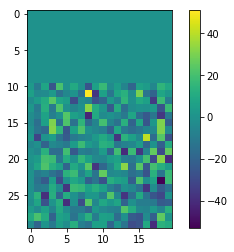

In [1498]:
# I NEED A BETTER IMAGE DISPLAY!
if True:
    im_sub=im[0:30,0:20]#-np.median(im)
    #plt.figure(figsize=(11, 5))
    #plt.subplot(1, 1, 1)
    plt.imshow(im_sub)
    plt.colorbar()
    hdu_list.close()

In [1499]:
# remove hot/bad pixels
from scipy.ndimage import median_filter
blurred = median_filter(im, size=3)
difference = im - blurred
threshold = 10*np.std(difference)
im_badpix_corr = np.empty_like(im)
im_badpix_corr[:] = im
#im_badpix_corr[difference>threshold] = 0

In [1500]:
# Find star by convolution with gaussian, then grab the max
star_finder_img=gaussian_filter(im,[5,5],order=0, mode='constant',cval=0)

# Cut out the area with the 1st order image
half_side = 20
zero_ord_pos = [1898, 403]
ymin = zero_ord_pos[0]-half_side if zero_ord_pos[0]-half_side > 0 else 0
ymax = zero_ord_pos[0]+half_side if zero_ord_pos[0]+half_side < 2047 else 2047
xmin = zero_ord_pos[1]-half_side if zero_ord_pos[1]-half_side > 0 else 0
xmax = zero_ord_pos[1]+half_side if zero_ord_pos[1]+half_side < 512 else 512
if True:
    print('Cutting out area with zero order image')
    print('ymin,ymax,xmin,xmax = [{}, {}, {}, {}]'.format(ymin,ymax,xmin,xmax))
    star_finder_img[ymin:ymax,xmin:xmax] = -1e9 #np.nan

# If the wavelength is longer than 700nm, then there will be 2nd order contamination.
# This means that the "star" finder below will find the wrong peak if the 2nd order is brighter than the first.
if popt[1] > 700:
    print('Removing 2nd order light from star finding image')
    #star_finder_img[800::,:]=-1e99

#print(np.max(star_finder_img))
value=None
ind=np.argmax(star_finder_img)
ind2d = np.unravel_index(ind,star_finder_img.shape)
print('centroid at y,x: {} {}'.format(ind2d[0],ind2d[1]))

Cutting out area with zero order image
ymin,ymax,xmin,xmax = [1878, 1918, 383, 423]
centroid at y,x: 1003 389


In [1501]:
#ind2d=[947,338]
#ind2d=[622,331]

In [1502]:
# Create sub-image
#ymin=1800 ; ymax=2048
#xmin=280 ; xmax=450
half_side=int(30)
ymin = ind2d[0]-half_side if ind2d[0]-half_side > 0 else 0
ymax = ind2d[0]+half_side if ind2d[0]+half_side < 2047 else 2047
xmin = ind2d[1]-half_side if ind2d[1]-half_side > 0 else 0
xmax = ind2d[1]+half_side if ind2d[1]+half_side < 512 else 512
print('subimage being made from ymin,ymax,xmin,xmax:{} {} {} {}'.format(ymin,ymax,xmin,xmax))
# new maximum at:
ind=np.argmax(im[ymin:ymax,xmin:xmax])
ind2d = np.unravel_index(ind,im[ymin:ymax,xmin:xmax].shape)
print('new centroid at y,x: {} {}'.format(ind2d[0],ind2d[1]))

subimage being made from ymin,ymax,xmin,xmax:973 1033 359 419
new centroid at y,x: 29 30


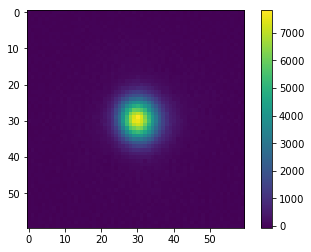

In [1503]:
im_sub=im[ymin:ymax,xmin:xmax]
# Gaussian doesn't do zero offet, so have to subtract...
im_sub_bkg_sub=im_sub-np.median(im_sub)

#im_sub=star_finder_img[ymin:ymax,xmin:xmax]
plt.imshow(im_sub)
plt.colorbar()
hdu_list.close()

29
30


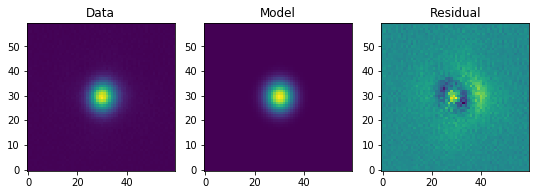

In [1504]:
# Generate x,y,z data
y, x = np.mgrid[:im_sub.shape[0], :im_sub.shape[1]]
print(y[ind2d])
print(x[ind2d])
z=im_sub_bkg_sub
# Fit the data using astropy.modeling
p_init = models.Gaussian2D(amplitude=np.nanmax(z),x_mean=x[ind2d], y_mean=y[ind2d], fixed={'theta':True})
#p_init = models.Gaussian2D(amplitude=np.nanmax(z),x_mean=38, y_mean=51, x_stddev=3, y_stddev=3,  fixed={'theta':True})
fit_p = fitting.LevMarLSQFitter()

with warnings.catch_warnings():
    # Ignore model linearity warning from the fitter
    warnings.simplefilter('ignore')
    p = fit_p(p_init, x, y, z)

# Plot the data with the best-fit model
plt.figure(figsize=(9, 5))
plt.subplot(1, 3, 1)
plt.imshow(z, origin='lower', interpolation='nearest')#, vmin=-1e4, vmax=5e4)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.imshow(p(x, y), origin='lower', interpolation='nearest')#, vmin=-1e4, vmax=5e4)
plt.title("Model")
plt.subplot(1, 3, 3)
plt.imshow(z - p(x, y), origin='lower', interpolation='nearest')#, vmin=-1e4, vmax=5e4)
plt.title("Residual")

In [1]:
print(['filename', p.param_names[0:5],'wavelength'])
print('{}, {:0.3f}, {:0.3f}, {:0.3f}, {:0.3f}, {:0.3f}, {:0.2f}'.format(
    atcamera_fname, p.amplitude.value, p.x_mean.value, p.y_mean.value,
    p.x_stddev.value, p.y_stddev.value,popt[1]))

NameError: name 'p' is not defined

In [1484]:
# AT_O_20190412_000007-ats-wfs_ccd.fits, 3994.556, 29.672, 30.017, 2.959, 3.066, 420.45


## Make an encircled energy and radial PSFs plots

In [1485]:
# Build 2d index arrays for calculations
pix_index_1d_arr=np.arange(0,2*half_side,1)
ones_array_2d=np.ones([2*half_side,2*half_side])

x_index_arr_2d=pix_index_1d_arr*ones_array_2d
y_index_arr_2d=np.transpose(x_index_arr_2d)

In [1486]:
# Calculate the centroid
x_CofM = np.sum(x_index_arr_2d*im_sub)/np.sum(im_sub)
y_CofM = np.sum(y_index_arr_2d*im_sub)/np.sum(im_sub)
print('Gaussian Center [x,y] is: [{:0.3f},{:0.3f}]'.format(p.x_mean.value, p.y_mean.value))
print('Center of Mass [x,y] is: [{:0.3f},{:0.3f}]'.format(x_CofM, y_CofM))
# Print positions in image
x_img_peak = p.x_mean.value + xmin
y_img_peak = p.y_mean.value + ymin
x_img_CofM = x_CofM + xmin
y_img_CofM = y_CofM + ymin
print('Full Image Peak is at [y,x] = [{:0.3f},{:0.3f}]'.format(y_img_peak, x_img_peak))
print('Full Image CofM is at [y,x] = [{:0.3f},{:0.3f}]'.format(y_img_CofM, x_img_CofM))

Gaussian Center [x,y] is: [30.123,29.543]
Center of Mass [x,y] is: [30.440,29.536]
Full Image Peak is at [y,x] = [1002.543,389.123]
Full Image CofM is at [y,x] = [1002.536,389.440]


In [1487]:
if False:
    x_arr_2d=x_index_arr_2d - p.x_mean.value
    y_arr_2d= np.transpose(x_index_arr_2d) - p.y_mean.value
else:
    x_arr_2d=x_index_arr_2d - x_CofM
    y_arr_2d= np.transpose(x_index_arr_2d) - y_CofM
        
    # create array of radial distances (in pixels)
r_arr_2d=np.sqrt(x_arr_2d**2 + y_arr_2d**2)

In [1342]:
if False:
    plt.imshow(r_arr_2d)
    plt.colorbar()

In [1343]:
r_arr_1d=np.reshape(r_arr_2d, (2*half_side)**2)
z_values_1d = np.reshape(im_sub_bkg_sub,(2*half_side)**2)
z_values_1d = np.reshape(im_sub,(2*half_side)**2)

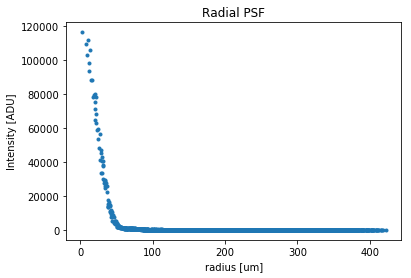

In [1344]:
if True:
    plt.ylabel('Intensity [ADU]')
    plt.plot(r_arr_1d*10, z_values_1d, '.')
    plt.title('Radial PSF')
    plt.xlabel('radius [um]')
    plt.show()
    plt.close()

In [1345]:
# sort the arrays so they're easier to loop/bin
ind= np.argsort(r_arr_1d)
ordered_r_arr_1d = r_arr_1d[ind]
ordered_z_values_1d = z_values_1d[ind]

In [1346]:
rad_pix_list = [] # is it better to append to lists? or can you append to numpy arrays?
E_wrt_rad_list = []
EE_arr_list = []
total_flux = sum(ordered_z_values_1d)
rad=0
dx0=0.5
dx=dx0
while rad < np.nanmax(ordered_r_arr_1d):  
    ind1 = ordered_r_arr_1d < (rad+dx)
    ind2 = ordered_r_arr_1d > (rad)
    good = ind1*ind2
    if sum(good) > 0:
        rad_pix_list.append(rad+dx/2) # center of the bin
        E_wrt_rad_list.append(sum(ordered_z_values_1d[good])/total_flux)
        EE_arr_list.append(sum(E_wrt_rad_list))
        
        dx=dx0
        rad+=dx
    else:
        dx+=1
    #print('rad and dx are {}, {}'.format(rad,dx))

In [1347]:
# Print the values at radii of 67 and 80%
EE_rad67_pix, EE_rad80_pix = np.interp([0.67, 0.80], np.array(EE_arr_list), np.array(rad_pix_list))
print('EE radius at 67% and 80% is [{:0.3f}, {:0.3f}] pixels'.format(EE_rad67_pix, EE_rad80_pix))
#EE_rad80_pix

EE radius at 67% and 80% is [2.758, 3.215] pixels


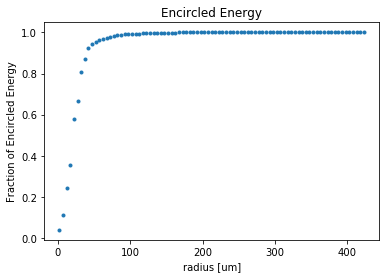

In [1348]:
if True:
    plt.ylabel('Fraction of Encircled Energy')
    plt.plot(10*np.array(rad_pix_list), EE_arr_list, '.')
    plt.title('Encircled Energy')
    plt.xlabel('radius [um]')
    plt.show()
    plt.close()

In [1070]:
# Create a dictionary if it's not already present
# A boolean of an empty dictionary is false

if not bool(data_dict):
    print('Adding new keys to dictionary')
    data_dict = {'fiberspec_wavelength': [], 'fiberspec_FWHM': [], 'fiberspec_Amp': [],
            'x_peak': [], 'y_peak': [], 'x_CofM': [], 'y_CofM': [],
            'Gauss_xFWHM_pix': [], 'Gauss_yFWHM_pix': [],
             'EE_rad67_pix': [], 'EE_rad80_pix': []} 

Adding new keys to dictionary


In [1071]:
data_dict['fiberspec_wavelength'].append(popt[1])
data_dict['fiberspec_FWHM'].append(popt[2]*2.355)
data_dict['fiberspec_Amp'].append(popt[0])

data_dict['x_peak'].append(x_img_peak)
data_dict['y_peak'].append(y_img_peak)
data_dict['x_CofM'].append(x_img_CofM)
data_dict['y_CofM'].append(y_img_CofM)

data_dict['Gauss_xFWHM_pix'].append(p.x_stddev.value)
data_dict['Gauss_yFWHM_pix'].append(p.y_stddev.value)
data_dict['EE_rad67_pix'].append(EE_rad67_pix)
data_dict['EE_rad80_pix'].append(EE_rad80_pix)

In [1072]:
np.argsort(data_dict['fiberspec_wavelength'])

array([0])

In [1073]:
f = open("dispersion_dictionary.pkl","wb")
pickle.dump(dict,f)
f.close()

#favorite_color = pickle.load( open( "save.p", "rb" ) ))

In [1074]:
# Fit a guassian to the profile

xdata = np.array(data_dict['y_peak'])
ydata = np.array(data_dict['fiberspec_wavelength'])

def line(x,m,b):
    return m*x+b

popt,pcov = curve_fit(line,xdata,ydata)#,p0=[])

plt.ylabel('wavelength [nm]')
plt.plot(xdata, ydata, '.')
plt.plot(xdata, line(xdata, *popt))
plt.title('Dispersion Plot')
plt.xlabel('y-pixel')
plt.show()
plt.close()

print('Dispersion is {} nm/pixel'.format(popt[0]))
print('Intercept is at pixel {}'.format(popt[1]))

TypeError: Improper input: N=2 must not exceed M=1

630.740553411 29.5293176809


In [713]:
for wave_ind in np.argsort(data_dict['fiberspec_wavelength']):
    print('{}, {}'.format(data_dict['fiberspec_wavelength'][wave_ind],data_dict['EE_rad80_pix'][wave_ind]))

426.594701968971, 2.594061472861331
467.56997420590085, 1.5288206167004277
529.399752381288, 3.2698663725381283
630.7405534106381, 29.52931768089633
729.9576632407392, 2.9649677952105695
834.039060106424, 4.631299963845259
939.323564016945, 6.821461636384678
